# Lab:  Neural Networks for Music Classification

In addition to the concepts in the demo for this unit, in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



In [1]:
#pip install --upgrade cffi

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/pip/__main__.py", line 19, in <module>
    sys.exit(_main())
  File "/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/opt/anaconda3/lib/python3.7/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib

## Loading the PyTorch package

We begin by loading PyTorch and the other packages.  If you have not already installed the PyTorch package on your computer, you may need to do so.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch

## Audio Feature Extraction with Librosa

The key to accurate audio classification is to extract good features. In addition to `torch`, we will use the `librosa` package.  The `librosa` package in python has a rich set of audio feature extraction methods for machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  After you have installed the package, you should be able to import it as follows.

In [3]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has great files for audio processing.  We will use the `requests.get` and `file.write` commands to load the file from a given URL into the working directory.

In [4]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

req = requests.get(url)
with open(fn, "wb") as file:        
    file.write(req.content) # write to file

If the above fails, you may need to install `requests` with `conda install requests`.

Next, we'll use the `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [5]:
y, sr = librosa.load(fn)

Let's play the audio file.  You should hear a soprano saxaphone playing four notes (C, C#, D, Eb).

In [6]:
# TODO: play audio file using IPython.display
import IPython.display as ipd
ipd.Audio(y, rate=sr) # load a NumPy array

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called "mel" spectrogram, which represents both frequency and power in the log domain.  This is motivated by human perceptual processing, which does something similar.  The code below displays the mel spectrogram of the audio sample.

The spectrogram clearly shows the four notes played in the audio track.  It also shows the "harmonics" of each note, which are the frequency components at integer multiples of the fundamental frequency of each note.

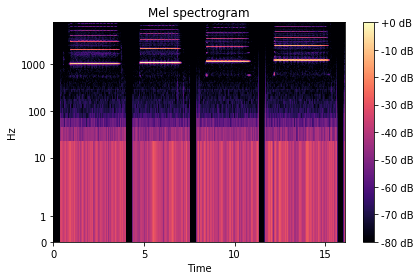

In [7]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above and, for each audio file, they segmented the track into notes and then extracted 120 MFCCs for each note.  The goal was to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say, `instrument_dataset`.  Then, load the data into numpy arrays as follows.

In [8]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

From these data files, write code that prints out:
* the number of training and test samples
* the number of features in each sample
* the number of classes (i.e., instruments to recognize)

In [9]:
# TODO
ntr = Xtr.shape[0]
nf = Xtr.shape[1]
nts = Xts.shape[0]
lables_count = len(np.unique(ytr))
print(f"number of traning samples: {ntr}, number of testing samples: {nts}, number of features: {nf}, number of classes: {lables_count}")
np.unique(ytr)

number of traning samples: 66247, number of testing samples: 14904, number of features: 120, number of classes: 10


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Before continuing, we will standardize the training and test data, `Xtr` and `Xts`.  First compute the mean and std deviation of each feature in `Xtr`.  Then create a new training data set, `Xtr_scale`, by subtracting the feature means from `Xtr` and dividing by the feature std deviations.  Then create a standardized test dataset, `Xts_scale`, **using the mean and std deviation computed on the training dataset**.

In [10]:
# TODO Scale the training and test matrices
Xtr_scale = (Xtr-np.mean(Xtr,0))/np.std(Xtr,0)
Xts_scale = (Xts-np.mean(Xts,0))/np.std(Xts,0)

## Create DataLoaders

To use PyTorch, we first create a Dataloader using the `TensorDataset` and `DataLoader` commands, just as in the demos. We will use `batch_size = 100`.

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 100

# TODO Convert the numpy arrays to tensors
Xtr_torch = torch.Tensor(Xtr_scale)
ytr_torch = torch.Tensor(ytr)
Xts_torch = torch.Tensor(Xts_scale)
yts_torch = torch.Tensor(yts)

# TODO Create a training/test dataset from the tensors
train_ds = torch.utils.data.TensorDataset(Xtr_torch, ytr_torch)
test_ds = torch.utils.data.TensorDataset(Xts_torch, yts_torch)


# TODO Create a training/test data loader from datasets
train_loader = torch.utils.data.DataLoader(train_ds,batch_size=100) 
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=100) 

## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb), create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation

Make sure to select the input and output dimensions correctly, and print the model summary.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# TODO: construct the model
nin = 120
nout = 10
nh = 256

# TODO Create Net class
# nin: dimension of input data
# nh: number of hidden units
# nout: number of outputs
class Net(nn.Module):
    def __init__(self,nin,nh,nout):
        super(Net,self).__init__()
        self.activation = nn.Sigmoid()
        self.Dense1 = nn.Linear(nin,nh)
        self.Dense2 = nn.Linear(nh,nout)
        
    def forward(self,x):
        x = self.activation(self.Dense1(x))
        #out = F.softmax(self.Dense2(x))
        out = self.Dense2(x)
        
        return out

# Initialize network
model = Net(nin=nin, nh=nh, nout=nout)

# Print string representation
print(str(model))

Net(
  (activation): Sigmoid()
  (Dense1): Linear(in_features=120, out_features=256, bias=True)
  (Dense2): Linear(in_features=256, out_features=10, bias=True)
)


## Training the Network

Next, select an optimizer (linked to the parameters of your new model) and a loss function. For the optimizer, we suggest to start with the Adam optimizer with a learning rate of 0.001.

In [13]:
import torch.optim as optim

lr = 1e-3

# TODO
opt = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss()

Train the model for 10 epochs using the scaled training data.  For **every batch**, record the training loss. 
For **every epoch**, record the training accuracy, the test loss, and the test accuracy.  Use the variable names defined below.  The code should be similar to that in the MNIST demo.

In [14]:
# TODO Train model for 10 epochs
num_epoch = 10

a_tr_loss = np.zeros([num_epoch])
a_tr_accuracy = np.zeros([num_epoch])
a_ts_loss = np.zeros([num_epoch])
a_ts_accuracy = np.zeros([num_epoch])

for epoch in range(num_epoch):
    model.train()
    correct=0
    total=0
    batch_loss_tr=[]
    
    for train_tier, data in enumerate(train_loader):
        x_batch, y_batch = data
        y_batch = y_batch.type(torch.long)
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch)
        batch_loss_tr.append(loss.item())
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        # Do hard classification: index of largest score
        _, predicted = torch.max(out.data, 1)
        # Compute number of decision errors
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    a_tr_loss[epoch] = np.mean(batch_loss_tr) # Compute average loss over epoch
    a_tr_accuracy[epoch] = 100*correct/total
    
    model.eval() # put model in evaluation mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss_ts = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            labels = labels.type(torch.long)
            outputs = model(images)
            batch_loss_ts.append(criterion(outputs,labels).item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    a_ts_loss[epoch] = np.mean(batch_loss_ts)
    a_ts_accuracy[epoch] = 100*correct/total
    # Print details every print_mod epoch
    print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
          +'Train Acc: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch])
          +'Test Acc: {0:.2f}'.format(a_ts_accuracy[epoch]))



Epoch:  1   Train Loss: 1.014   Train Acc: 80.11    Test Loss: 6.011   Test Acc: 21.92
Epoch:  2   Train Loss: 0.786   Train Acc: 81.19    Test Loss: 4.144   Test Acc: 25.18
Epoch:  3   Train Loss: 0.588   Train Acc: 82.68    Test Loss: 3.429   Test Acc: 28.17
Epoch:  4   Train Loss: 0.474   Train Acc: 84.26    Test Loss: 2.928   Test Acc: 32.34
Epoch:  5   Train Loss: 0.420   Train Acc: 85.85    Test Loss: 2.730   Test Acc: 34.67
Epoch:  6   Train Loss: 0.375   Train Acc: 86.82    Test Loss: 2.567   Test Acc: 38.17
Epoch:  7   Train Loss: 0.331   Train Acc: 87.73    Test Loss: 2.326   Test Acc: 42.79
Epoch:  8   Train Loss: 0.288   Train Acc: 88.91    Test Loss: 2.100   Test Acc: 49.03
Epoch:  9   Train Loss: 0.253   Train Acc: 90.14    Test Loss: 1.958   Test Acc: 54.20
Epoch: 10   Train Loss: 0.228   Train Acc: 90.94    Test Loss: 1.850   Test Acc: 57.94


Plot the test accuracy versus epoch, as saved in `a_ts_accuracy`. You should see a final accuracy $> 99\%$.

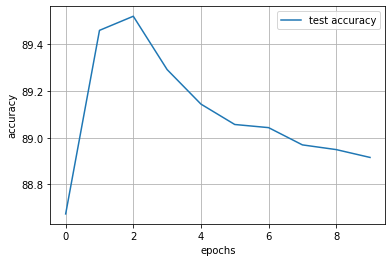

In [19]:
# TODO
plt.plot(a_ts_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['test accuracy'])

Plot the loss **versus batch**, as saved in `a_tr_loss`, using `semilogy`.  But label the x-axis in units of epochs.  Note that the relation between the epoch and batch index `i` is `epoch = i*batch_size/ntr`, given `batch_size` and a total of `ntr` training samples.

Text(0, 0.5, 'loss')

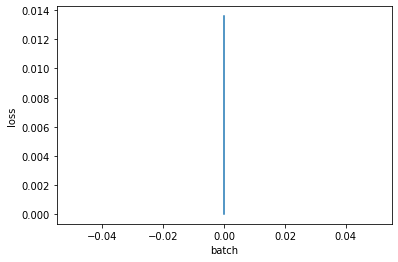

In [20]:
# TODO
x = [i*batch_size/ntr for i in range(len(a_tr_loss))]
plt.plot(a_tr_loss,x)
plt.xlabel('batch')
plt.ylabel('loss')

### Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Re-run the above code inside a for loop that trys the 3 learning rates given in the vector `rates`.  For each learning rate:
* instantiate the model (which resets the learned parameters),
* construct the optimizer (i.e., Adam with the appropriate learning rate),
* train the model,
* record the loss versus batch and accuracy versus epoch, as before.

In [21]:
rates = [0.01,0.001,0.0001]
loss_hist = [[] for i in range(3)]
val_acc_hist = []

# TODO
for i in range(3):
    opt = optim.Adam(model.parameters(), rates[i])
    
    # TODO Train model for 10 epochs
    num_epoch = 10

    a_tr_loss = np.zeros([num_epoch])
    a_tr_accuracy = np.zeros([num_epoch])
    a_ts_loss = np.zeros([num_epoch])
    a_ts_accuracy = np.zeros([num_epoch])

    for epoch in range(num_epoch):
        model.train()
        correct=0
        total=0
        batch_loss_tr=[]
    
        for train_tier, data in enumerate(train_loader):
            x_batch, y_batch = data
            y_batch = y_batch.type(torch.long)
            out = model(x_batch)
            # Compute Loss
            loss = criterion(out,y_batch)
            batch_loss_tr.append(loss.item())
            # Compute gradients using back propagation
            opt.zero_grad()
            loss.backward()
            # Take an optimization 'step'
            opt.step()
            # Do hard classification: index of largest score
            _, predicted = torch.max(out.data, 1)
            # Compute number of decision errors
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
        loss_hist[i].append(np.mean(batch_loss_tr)) # Compute average loss over epoch
        a_tr_accuracy[epoch] = 100*correct/total
    
        model.eval() # put model in evaluation mode
        correct = 0 # initialize error counter
        total = 0 # initialize total counter
        batch_loss_ts = []
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                labels = labels.type(torch.long)
                outputs = model(images)
                batch_loss_ts.append(criterion(outputs,labels).item())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
        a_ts_loss[epoch] = np.mean(batch_loss_ts)
        a_ts_accuracy[epoch] = 100*correct/total
        # Print details every print_mod epoch
        print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, loss_hist[i][epoch])
          +'Train Acc: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch])
          +'Test Acc: {0:.2f}'.format(a_ts_accuracy[epoch]))
    
    

Epoch:  1   Train Loss: 0.257   Train Acc: 96.69    Test Loss: 14.394   Test Acc: 45.26
Epoch:  2   Train Loss: 0.834   Train Acc: 93.22    Test Loss: 12.306   Test Acc: 42.00
Epoch:  3   Train Loss: 0.525   Train Acc: 93.89    Test Loss: 9.912   Test Acc: 55.96
Epoch:  4   Train Loss: 0.739   Train Acc: 92.82    Test Loss: 9.847   Test Acc: 52.18
Epoch:  5   Train Loss: 0.753   Train Acc: 93.31    Test Loss: 6.744   Test Acc: 65.24
Epoch:  6   Train Loss: 0.732   Train Acc: 93.48    Test Loss: 9.240   Test Acc: 55.70
Epoch:  7   Train Loss: 0.683   Train Acc: 94.16    Test Loss: 4.244   Test Acc: 71.38
Epoch:  8   Train Loss: 0.654   Train Acc: 94.93    Test Loss: 7.561   Test Acc: 58.11
Epoch:  9   Train Loss: 0.508   Train Acc: 95.49    Test Loss: 4.030   Test Acc: 70.34
Epoch: 10   Train Loss: 0.434   Train Acc: 96.36    Test Loss: 5.587   Test Acc: 62.82
Epoch:  1   Train Loss: 1.195   Train Acc: 88.57    Test Loss: 1.654   Test Acc: 83.89
Epoch:  2   Train Loss: 0.510   Train Acc

Plot the loss vs. batch index (again labeling the x-axis in units of epochs) for all three learning rates on one graph.  You should see that, at a lower learning rate, the loss is more stable but converges more slowly.

Text(0, 0.5, 'loss')

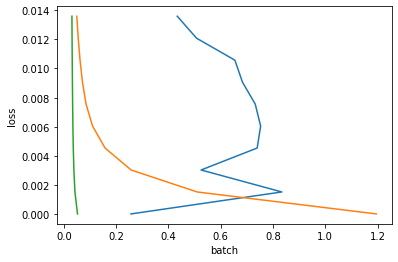

In [22]:
# TODO
x = [i*batch_size/ntr for i in range(len(loss_hist[0]))]
plt.plot(loss_hist[0],x)
plt.plot(loss_hist[1],x)
plt.plot(loss_hist[2],x)
plt.xlabel('batch')
plt.ylabel('loss')